In [26]:
import geopandas as gpd
from pyproj import CRS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pycountry

In [27]:

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.loc[countries['name'] == 'France', 'iso_a3'] = 'FRA'
countries.loc[countries['name'] == 'Norway', 'iso_a3'] = 'NOR'
countries.loc[countries['name'] == 'N. Cyprus', 'iso_a3'] = 'CYP'
countries.loc[countries['name'] == 'Somaliland', 'iso_a3'] = 'SOM'
countries.loc[countries['name'] == 'Kosovo', 'iso_a3'] = 'RKS'

objects = pd.read_csv('./startup-investments/objects.csv')
pd.set_option('display.max_columns', None)
objects.head()

<ipython-input-27-19f64065beb7>:8: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  objects = pd.read_csv('./startup-investments/objects.csv')


,id,entity_type,entity_id,parent_id,name,normalized_name,permalink,category_code,status,founded_at,closed_at,domain,homepage_url,twitter_username,logo_url,logo_width,logo_height,short_description,description,overview,tag_list,country_code,state_code,city,region,first_investment_at,last_investment_at,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships,created_by,created_at,updated_at
0,c:1,Company,1,NaN,Wetpaint,wetpaint,/company/wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,http://wetpaint-inc.com,BachelrWetpaint,http://s3.amazonaws.com/crunchbase_prod_assets...,401,54,NaN,Technology Platform Company,Wetpaint is a technology platform company that...,"wiki, seattle, elowitz, media-industry, media-...",USA,WA,Seattle,Seattle,NaN,NaN,0,0,2005-10-01,2008-05-19,3,39750000.0,2010-09-05,2013-09-18,5,17,initial-importer,2007-05-25 06:51:27,2013-04-13 03:29:00
1,c:10,Company,10,NaN,Flektor,flektor,/company/flektor,games_video,acquired,NaN,NaN,flektor.com,http://www.flektor.com,NaN,http://s3.amazonaws.com/crunchbase_prod_assets...,186,85,NaN,NaN,Flektor is a rich-media mash-up platform that ...,"flektor, photo, video",USA,CA,Culver City,Los Angeles,NaN,NaN,0,0,NaN,NaN,0,0.0,NaN,NaN,0,6,initial-importer,2007-05-31 21:11:51,2008-05-23 23:23:14
2,c:100,Company,100,NaN,There,there,/company/there,games_video,acquired,NaN,NaN,there.com,http://www.there.com,NaN,http://s3.amazonaws.com/crunchbase_prod_assets...,107,34,NaN,NaN,There.com is an online virtual world where any...,"virtualworld, there, teens",USA,CA,San Mateo,SF Bay,NaN,NaN,0,0,NaN,NaN,0,0.0,2003-02-01,2011-09-23,4,12,initial-importer,2007-08-06 23:52:45,2013-11-04 02:09:48
3,c:10000,Company,10000,NaN,MYWEBBO,mywebbo,/company/mywebbo,network_hosting,operating,2008-07-26,NaN,mywebbo.com,http://www.mywebbo.com,NaN,NaN,0,0,NaN,NaN,"BRAND NEW ONLINE SOCIAL NETWORKING WEBSITE,FOR...","social-network, new, website, web, friends, ch...",NaN,NaN,NaN,unknown,NaN,NaN,0,0,NaN,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-08-24 16:51:57,2008-09-06 14:19:18
4,c:10001,Company,10001,NaN,THE Movie Streamer,the movie streamer,/company/the-movie-streamer,games_video,operating,2008-07-26,NaN,themoviestreamer.com,http://themoviestreamer.com,NaN,http://s3.amazonaws.com/crunchbase_prod_assets...,200,74,NaN,NaN,This company shows free movies online on their...,"watch, full-length, moives, online, for, free,...",NaN,NaN,NaN,unknown,NaN,NaN,0,0,NaN,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-08-24 17:10:34,2008-09-06 14:19:18


## Selecting important infomation from whole set

In [28]:
df_objects = objects[['id','entity_type','category_code','country_code']]

# only select Companies (get rid of people or other entities)
df_companies = df_objects.loc[df_objects['entity_type'] == 'Company']
df_companies = df_companies.drop('entity_type', axis=1)

df_companies = df_companies.dropna()
print("Got " + str(df_companies.shape[0]) + " datapoints")
df_companies.head(20)

Got 81218 datapoints


,id,category_code,country_code
0,c:1,web,USA
1,c:10,games_video,USA
2,c:100,games_video,USA
5,c:10002,advertising,MAR
6,c:10003,cleantech,IND
8,c:10005,advertising,USA
12,c:10009,advertising,USA
13,c:1001,web,USA
15,c:10011,games_video,USA
18,c:10014,mobile,USA


## Get most common Category for a Country

In [29]:
unique_c = df_companies["country_code"].unique()
df_unique_c = pd.DataFrame()
df_unique_c["country_code"] = unique_c
most_common = []
for country in unique_c:
    tmp_country = df_companies[df_companies["country_code"] == country]
    most_common.append(tmp_country["category_code"].value_counts().idxmax())


print(len(most_common))
print(unique_c.shape)
df_unique_c["category_code"] = most_common

df_unique_c

173
(173,)


,country_code,category_code
0,USA,software
1,MAR,ecommerce
2,IND,software
3,AUS,web
4,FRA,software
...,...,...
168,SYR,web
169,SOM,mobile
170,RWA,consulting
171,CIV,other


## Merge Map and Datapoints on city Name

In [30]:
print(df_unique_c[df_unique_c["country_code"] == "FRA"])
print(countries[countries["iso_a3"] == "FRA"])


  country_code category_code
4          FRA      software
     pop_est continent    name iso_a3  gdp_md_est  \
43  67106161    Europe  France    FRA   2699000.0   

                                             geometry  
43  MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...  


In [31]:
# cities = cities.rename(columns={"name":"city"})
# map_and_stats = cities.merge(df_companies, on="city")
# print(map_and_stats.shape[0])
# print(cities.shape[0])
# print(df_companies.shape[0])
# map_and_stats.head()

df_unique_c = df_unique_c.rename(columns={"country_code":"iso_a3"})
map_and_stats = countries.merge(df_unique_c, on="iso_a3")



print(map_and_stats.shape[0])
print(df_companies.shape[0])
map_and_stats.head()

139
81218


,pop_est,continent,name,iso_a3,gdp_md_est,geometry,category_code
0,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",travel
1,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",software
2,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",software
3,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",other
4,29748859,Asia,Uzbekistan,UZB,202300.0,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...",other


## Plot Data

In [32]:
map_and_stats["category_code"].unique()


array(['travel', 'software', 'other', 'ecommerce', 'mobile', 'web',
       'advertising', 'search', 'local', 'consulting', 'education',
       'public_relations', 'network_hosting', 'cleantech', 'health',
       'finance', 'games_video'], dtype=object)

<ipython-input-39-c6f40a7c598f>:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, alpha=0.5)


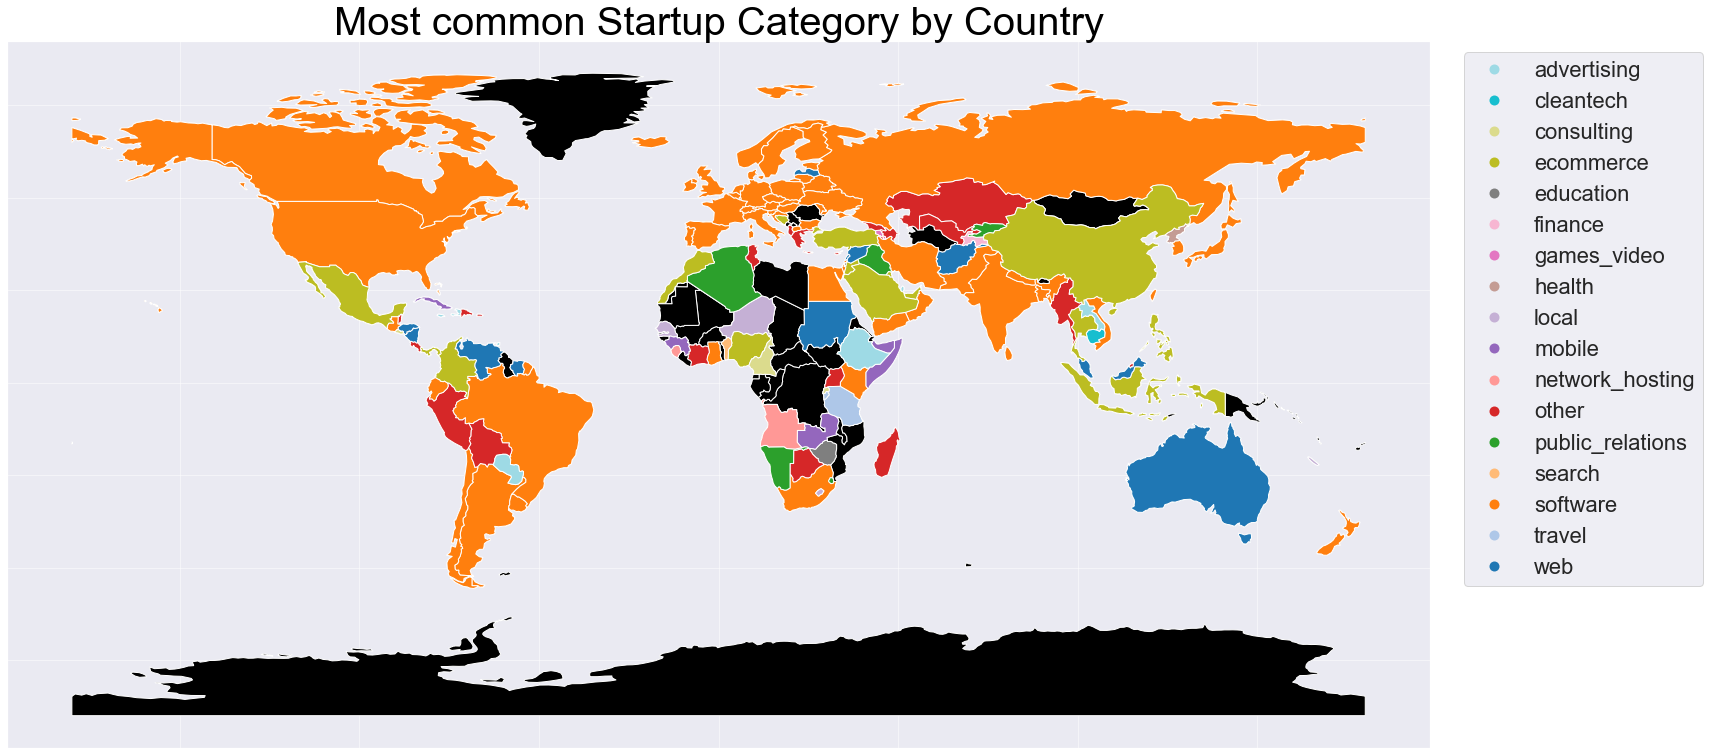

In [39]:
# initialize an axis
fig, ax = plt.subplots(figsize=(35,13))

# plot map on axis




countries.plot(color="black",ax=ax)# parse dates for plot's title

map_and_stats.plot(column="category_code",
                categorical=True,
                cmap='tab20_r',
                legend=True,
                ax=ax)
ax.set_title("Most common Startup Category by Country",color='black',fontdict={'fontsize':40})
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.2, 1.0))
# add grid
ax.grid(b=True, alpha=0.5)

ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelleft=False,
    labelbottom=False)

plt.savefig("worldmap_barplots/WorldMap.png")

plt.show()



## Plot Category for specific Country as Bar Plot in %

In [40]:
fig, ax = plt.subplots(figsize=(20,20))
sns.set(font_scale = 2)

threshold_num_startups = 1000

for country in df_companies["country_code"].unique():
    df_country = df_companies[df_companies["country_code"] == country]
    num_startups = df_country.shape[0]
    if num_startups > threshold_num_startups:
        percentages_categories = []
        unique_categories = df_country["category_code"].unique()

        for cat in unique_categories:
            sum = df_country[df_country["category_code"] == cat].shape[0]
            percentages_categories.append(sum/num_startups)

        df_country_category = pd.DataFrame()
        df_country_category["category"] = unique_categories
        df_country_category["percentage"] = percentages_categories

        palette = sns.color_palette("hls", df_country_category.shape[0])
        df_country_category = df_country_category.sort_values("percentage", ascending=False)
        g = sns.barplot(x="category", y="percentage",color="darkblue",data=df_country_category)
        g.set_title(pycountry.countries.get(alpha_3=country).name + " Startup categories in Percentages\n Sample Size = " + str(num_startups), fontsize=50)
        g.set_ylabel("Relative No. Startups", fontsize=30)
        g.set_xlabel("Category of Startup", fontsize=30)

        g.set_xticklabels(ax.get_xticklabels(),rotation=45, ha="right", fontdict={'fontsize':20})
        plt.savefig("worldmap_barplots/{0}.png".format(pycountry.countries.get(alpha_3=country).name))
        g.cla()

plt.close()

## Plot Results

[37 41 28 22  9  7  0 12  5  3 31 25 14  4  8 33 34  1 36 35 11 19 15 18
 17 10 26 16 40  6 30 23 32 39 20 21  2 24 27 29 13 38]


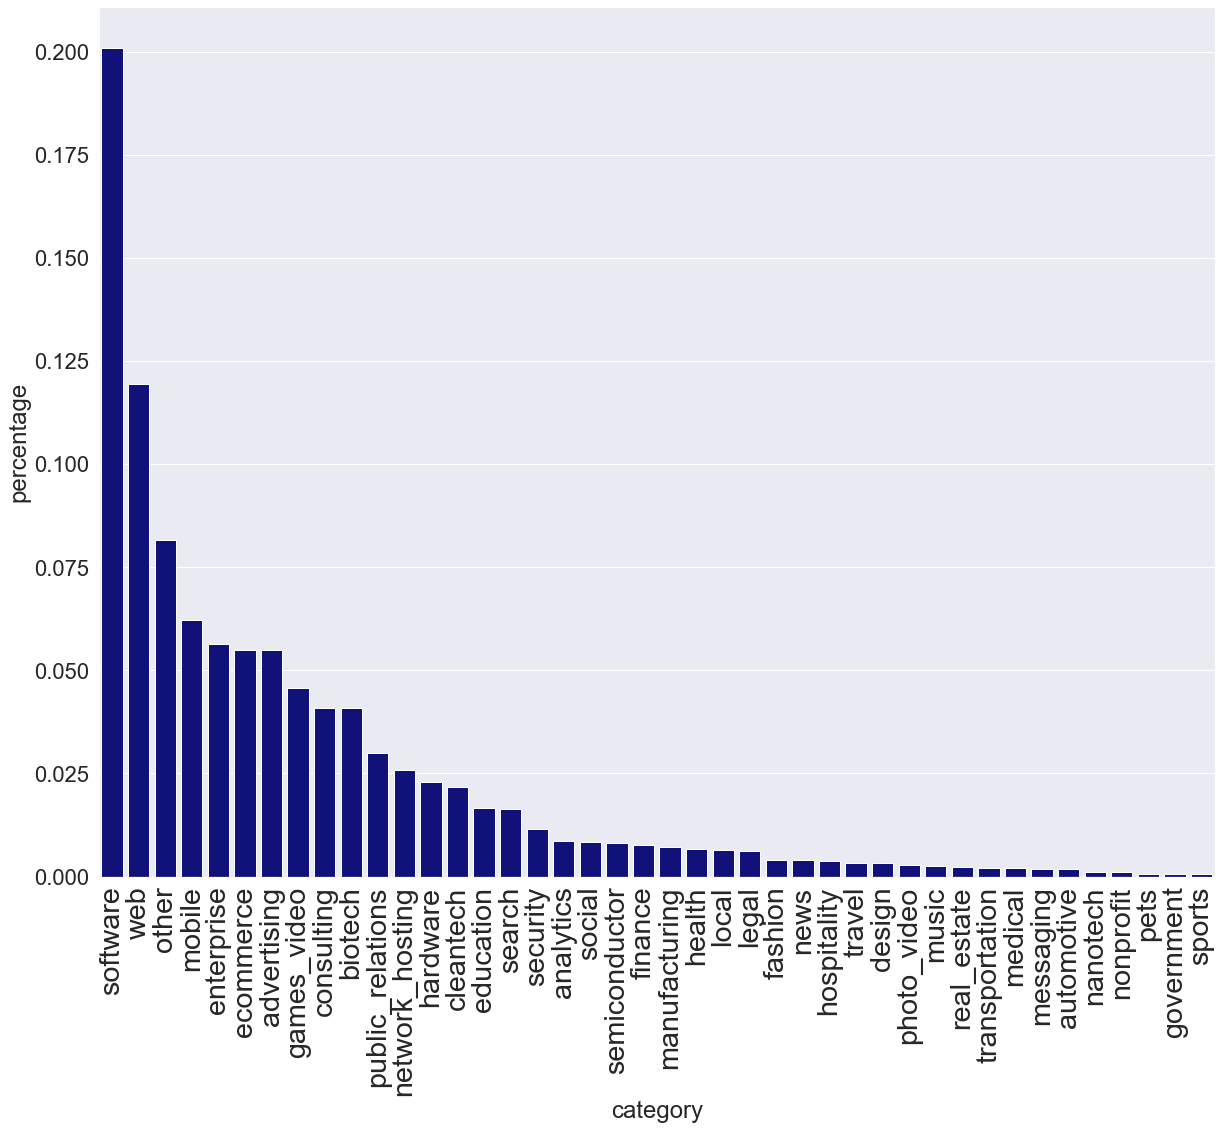

In [35]:
fig, ax = plt.subplots(figsize=(20,16))
palette = sns.color_palette("hls", df_country_category.shape[0])
color_values = pd.Categorical(df_country_category["category"]).codes
print(color_values)
df_country_category = df_country_category.sort_values("percentage", ascending=False)
#plt.bar(x=df_country_category['category'], height=df_country_category['percentage'], color=color_values)
g = sns.barplot(x="category", y="percentage",color="darkblue",data=df_country_category)
g.tick_params(axis='x', rotation=90, labelsize="large", labelbottom=True)